## DNA Sequencing With Machine Learning

In this notebook, I will apply a classification model that can predict a gene's function based on the DNA sequence of the coding sequence alone.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading the data, beacuse it was in table format
human= pd.read_table('human_data.txt')
human.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


### We have some data for human DNA sequence coding regions and a class label.  We also have data for Chimpanzee and a more divergent species, the dog.

In [3]:
chimp= pd.read_table('chimp_data.txt')
dog= pd.read_table('dog_data.txt')
chimp.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


<AxesSubplot:>

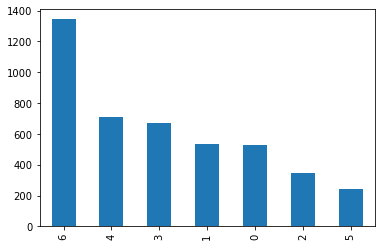

In [4]:
human['class'].value_counts().plot.bar()

<AxesSubplot:>

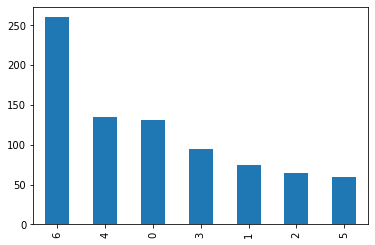

In [5]:
dog['class'].value_counts().plot.bar()

<AxesSubplot:>

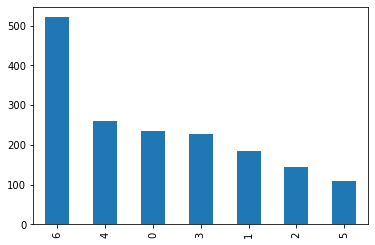

In [6]:
chimp['class'].value_counts().plot.bar()

In [7]:
# checking for missing values
human.isnull().sum()

sequence    0
class       0
dtype: int64

### Here are the definitions for each of the 7 classes and how many there are in the human training data.  They are gene sequence function groups.

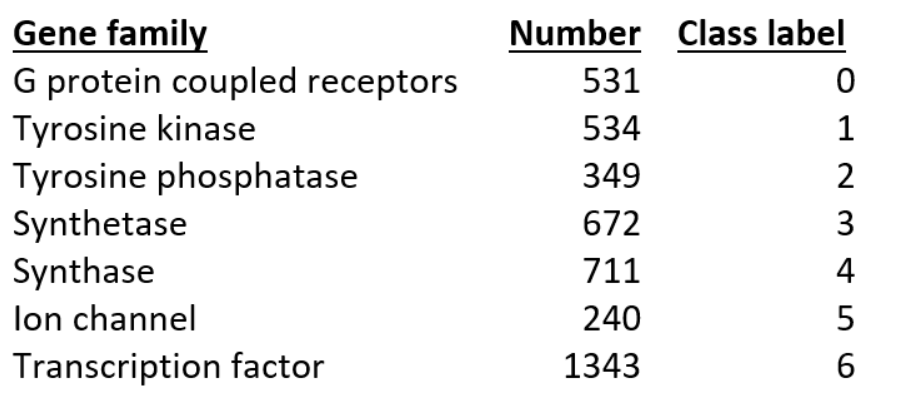

### Treating DNA sequence as a "language", otherwise known as  k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it supe easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [8]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getkmers(sequences,size=6):
    return[sequences[i:i+size].lower() for i in range(len(sequences)-size+1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [9]:
human['text']= human['sequence'].apply(getkmers)
human.drop('sequence',axis=1,inplace=True)


In [10]:
human.head()

,class,text
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [11]:
#dog
dog['text']= dog['sequence'].apply(getkmers)
dog.drop('sequence',axis=1,inplace=True)
#chimp
chimp['text']= chimp['sequence'].apply(getkmers)
chimp.drop('sequence',axis=1,inplace=True)
chimp.head()

,class,text
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
3,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
4,6,"[atgggc, tgggca, gggcag, ggcagc, gcagcg, cagcg..."


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We will remove the commas 

In [12]:
# make it in list
human_text= list(human['text'])
for i in range(len(human_text)):
    human_text[i]= ' '.join(human_text[i])
    

In [13]:
# lets see the 
human_text[1]

'atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaaat aaaatc aaatct aatctg atctgt tctgtt ctgttc tgttcg gttcgc ttcgct tcgctt cgcttc gcttca cttcat ttcatt tcattc cattca attcat ttcatt tcattg cattgc attgcc ttgccc tgcccc gccccc ccccca ccccac cccaca ccacaa cacaat acaatc caatcc aatcct atccta tcctag cctagg ctaggc taggcc aggcct ggccta gcctac cctacc ctaccc tacccg acccgc cccgcc ccgccg cgccgc gccgca ccgcag cgcagt gcagta cagtac agtact gtactg tactga actgat ctgatc tgatca gatcat atcatt tcattc cattct attcta ttctat tctatt ctattt tatttc atttcc tttccc ttcccc tccccc ccccct cccctc ccctct cctcta ctctat tctatt ctattg tattga attgat ttgatc tgatcc gatccc atcccc tcccca ccccac cccacc ccacct cacctc acctcc cctcca ctccaa tccaaa ccaaat caaata aaatat aatatc atatct tatctc atctca tctcat ctcatc tcatca catcaa atcaac tcaaca caacaa aacaac acaacc caaccg aaccga accgac ccgact cgacta gactaa actaat ctaatc taatca aatcac atcacc tcacca caccac accacc ccaccc caccca acccaa cccaac ccaaca caacaa aacaat acaatg caatga aatgac atgact tgacta gacta

In [14]:
dog_text= list(dog['text'])
for i in range(len(dog_text)):
    dog_text[i]= ' '.join(dog_text[i])

chimp_text= list(chimp['text'])
for i in range(len(chimp_text)):
    chimp_text[i]= ' '.join(chimp_text[i])

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [15]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer(ngram_range=(4,4))
X_human= cv.fit_transform(human_text) # Indepenedent features of human
X_dog= cv.fit_transform(dog_text)  # Indepenedent features of dog
X_chimp= cv.fit_transform(chimp_text)  # Indepenedent features of chimp

In [16]:

human.head(3)

,class,text
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."


<AxesSubplot:>

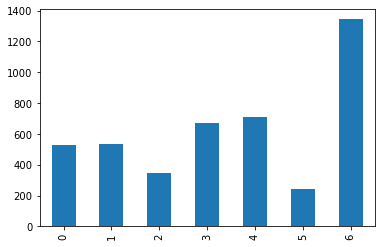

In [17]:
# Dependendent feature
y_data= human['class']
y_data.value_counts().sort_index(ascending=True).plot.bar()

In [18]:
#lets see the shape of data
print(X_human.shape)
print(X_dog.shape)
print(X_chimp.shape)

(4380, 232414)
(820, 227149)
(1682, 229684)


In [19]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_human,y_data,test_size=0.20,random_state=0)


### A multinomial naive Bayes classifier will be created.  I previously did some parameter tuning and found the ngram size of 4 (reflected in the Countvectorizer() instance) and a model alpha of 0.1 did the best.

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB(alpha=0.1) #hyperparameter 
nb.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

In [21]:
# predicting on test data
y_pred= nb.predict(X_test)


### Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score.  We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data.  In a real project I would go back and sample many more train test splits since we have a relatively small data set.

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
print('The accuracy of the model is', accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

The accuracy of the model is 0.9726027397260274
[[ 96   0   0   0   0   0   1]
 [  0 101   0   1   0   0   1]
 [  0   0  61   0   0   0   2]
 [  0   0   0 133   0   0   3]
 [  3   0   0   0 142   0  10]
 [  0   0   0   0   0  48   0]
 [  2   0   0   0   1   0 271]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        97
           1       1.00      0.98      0.99       103
           2       1.00      0.97      0.98        63
           3       0.99      0.98      0.99       136
           4       0.99      0.92      0.95       155
           5       1.00      1.00      1.00        48
           6       0.94      0.99      0.96       274

    accuracy                           0.97       876
   macro avg       0.98      0.97      0.98       876
weighted avg       0.97      0.97      0.97       876



In [23]:
dog.head(2)

,class,text
0,4,"[atgcca, tgccac, gccaca, ccacag, cacagc, acagc..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."


In [24]:
#dog
y_dog=dog['class']
X_train,X_test,y_train,y_test= train_test_split(X_dog,y_dog,test_size=0.20,random_state=0)
nb.fit(X_train,y_train)
y_pred= nb.predict(X_test)
print('The accuracy of the model is', accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

The accuracy of the model is 0.7317073170731707
[[16  0  0  1  0  1  0]
 [ 1 10  0  0  0  0  4]
 [ 0  0  6  1  0  0  6]
 [ 2  0  0 12  1  0  5]
 [ 4  0  0  2 12  3  6]
 [ 2  0  0  1  0  9  1]
 [ 1  0  0  1  0  1 55]]
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        18
           1       1.00      0.67      0.80        15
           2       1.00      0.46      0.63        13
           3       0.67      0.60      0.63        20
           4       0.92      0.44      0.60        27
           5       0.64      0.69      0.67        13
           6       0.71      0.95      0.81        58

    accuracy                           0.73       164
   macro avg       0.79      0.67      0.70       164
weighted avg       0.78      0.73      0.72       164



In [25]:
#Chimp
y_chimp=chimp['class']
X_train,X_test,y_train,y_test= train_test_split(X_chimp,y_chimp,test_size=0.20,random_state=0)
nb.fit(X_train,y_train)
y_pred= nb.predict(X_test)
print('The accuracy of the model is', accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

The accuracy of the model is 0.9080118694362018
[[ 40   0   0   0   1   0   7]
 [  0  36   0   0   0   0   1]
 [  0   0  24   0   0   0   0]
 [  0   0   0  49   1   0   5]
 [  1   0   0   0  40   0   9]
 [  4   0   0   0   0  15   2]
 [  0   0   0   0   0   0 102]]
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        48
           1       1.00      0.97      0.99        37
           2       1.00      1.00      1.00        24
           3       1.00      0.89      0.94        55
           4       0.95      0.80      0.87        50
           5       1.00      0.71      0.83        21
           6       0.81      1.00      0.89       102

    accuracy                           0.91       337
   macro avg       0.95      0.89      0.91       337
weighted avg       0.92      0.91      0.91       337

